In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [74]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=2, threads_per_worker=2,dashboard_address=':9104')

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:9104/status,
Dashboard: http://127.0.0.1:9104/status,Workers: 2
Total threads: 4,Total memory: 62.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49503,Workers: 2
Dashboard: http://127.0.0.1:9104/status,Total threads: 4
Started: Just now,Total memory: 62.97 GiB
Comm: tcp://127.0.0.1:58615,Total threads: 2
Dashboard: http://127.0.0.1:38099/status,Memory: 31.49 GiB
Nanny: tcp://127.0.0.1:55433,


## 1. Packages

In [3]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import netCDF4 as nc
import xarray as xr
import pandas as pd
import glob
import datetime as dttime
from scipy.signal import find_peaks
from numpy.polynomial import Polynomial as P
from scipy import fftpack
from scipy import signal

'Functions from local module:'
import tools_V13 as tl

## 2. Data

In [5]:
#Mesh
fnm = '/home/silvatol/Documents/Stage/Codes/Data/mesh_zgr_eNATL60pDYF_3.6_0-2500m.nc'
#fnm = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/mesh_zgr_eNATL60pDYF_3.6_0-2500m.nc'
dsm = xr.open_dataset(fnm)

#Temperature
fnT = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_votemper_0-2500m.nc'
#fnT = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_votemper_0-2500m.nc'
dsT = xr.open_dataset(fnT)

#Salinity
fnS = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_vosaline_0-2500m.nc'
#fnS = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_vosaline_0-2500m.nc'
dsS = xr.open_dataset(fnS)

#Density
fnD = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_sig0_0-2500m.nc'
#fnS = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_sig0_0-2500m.nc'
dsD = xr.open_dataset(fnD)

#U current velocity
fnU = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_vozocrtx_0-2500m.nc'
#fnU = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_vozocrtx_0-2500m.nc'
dsU = xr.open_dataset(fnU)

#Ug current velocity
fnUg = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_ugeo.nc'
#fnUg = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_ugeo.nc'
dsUg = xr.open_dataset(fnUg)

#V current velocity
fnV = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_vomecrty_0-2500m.nc'
#fnV = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_vomecrty_0-2500m.nc'
dsV = xr.open_dataset(fnV)

#Vg current velocity
fnVg = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_vgeo.nc'
#fnVg = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_vgeo.nc'
dsVg = xr.open_dataset(fnVg)

#U10 wind velocity
fnU10 = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.3h_u10.nc'
#fnU10 = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.3h_u10.nc'
dsU10 = xr.open_dataset(fnU10)

#V10 wind velocity
fnV10 = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.3h_v10.nc'
#fnV10 = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.3h_v10.nc'
dsV10 = xr.open_dataset(fnV10)

#Wind velocity module
fnW = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.3h_wind10.nc'
#fnW = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.3h_wind10.nc'
dsW = xr.open_dataset(fnW)

#Tau_x wind stress
fntau_x = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_sozotaux.nc'
#fnU10 = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_sozotaux.nc'
dstau_x = xr.open_dataset(fntau_x)

#Tau_y wind stress
fntau_y = '/home/silvatol/Documents/Stage/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_sometauy.nc'
#fnU10 = 'C:/Users/ASUS/Downloads/Project 1D model/Codes/Data/eNATL60pDYF-BLB002_y2010m01d01-y2010m07d31.1h_sometauy.nc'
dstau_y = xr.open_dataset(fntau_y)

#Creation of Z levels vector

Zl = np.concatenate(([0],np.squeeze(dsm.e3t_1d))) # to modify the delta z vector from the NATL60 simulation
Zlev = np.cumsum(Zl) #levels in the sense of NATL60

#Define the levels to use in my code:

Zlevels = np.zeros_like(Zlev)
for j in range(0,len(Zlev)):
    Zlevels[j] = Zlev[-1]- Zlev[j]

depth_levels = np.zeros_like(dsT.deptht)
for l in range(0,len(dsT.deptht)):
    depth_levels [l] = dsT.deptht[-1]- dsT.deptht[l]

hide_toggle()

In [6]:
# NOTE: This is the time at which began the wind data
dayss = 3.473973e+09/86400
dates = dttime.timedelta(dayss)+dttime.datetime(year=1900,month=1,day=1)
print(dates)

from datetime import datetime
datetime_element = datetime(2010, 1, 1, 0, 36, 40)#This data comes from dates
date_element = datetime_element.date()

print(datetime_element)


2010-02-01 00:30:00
2010-01-01 00:36:40


In [7]:
#Remove some not desire coordinates and get values for wind velocity and geostrophic
U10 = dsU10.squeeze("x").squeeze("y").u10
V10 = dsV10.squeeze("x").squeeze("y").v10
tau_x = dstau_x.squeeze("x").squeeze("y").sozotaux
tau_y = dstau_y.squeeze("x").squeeze("y").sometauy
Ug = dsUg.squeeze("x").squeeze("y").uo
Vg = dsVg.squeeze("x").squeeze("y").vo

#Remove some not desire coordinates for temperature and salinity
T = dsT.squeeze("x").squeeze("y").votemper.sel(deptht=slice(0,302))
S = dsS.squeeze("x").squeeze("y").vosaline.sel(deptht=slice(0,302))
U = dsU.squeeze("x").squeeze("y").vozocrtx.sel(depthu=slice(0,302))
V = dsV.squeeze("x").squeeze("y").vomecrty.sel(depthv=slice(0,302))

#Interpolation along the dept to have a DeltaZ = 1m
#new_depth = np.linspace(4.804548e-01,301.86157,301)
new_depth = np.linspace(4.804548e-01,301.86157,151)
new_depth_vel = np.linspace(4.804548e-01,301.86157,302)

Ti = T.interp(deptht=new_depth)
Ti[:,-1] = T[:,-1]
Td = Ti.transpose() #Change of the order of the coordinates to match with the formulation of the code (depth, time)

Si = S.interp(deptht=new_depth)
Si[:,-1] = S[:,-1]
Sd = Si.transpose() #Change of the order of the coordinates to match with the formulation of the code (depth, time)

Ui = U.interp(depthu=new_depth_vel)
Ui[:,-1] = U[:,-1]
Ut = Ui.transpose()

Vi = V.interp(depthv=new_depth_vel)
Vi[:,-1] = V[:,-1]
Vt = Vi.transpose()

#Data of temperature and salinity

winter_day = '2010-01-31T12:30:00.000000000'
spring_day = '2010-04-30T12:30:00.000000000'
summer_day = '2010-07-31T12:30:00.000000000'

T_win = Ti.sel(time_counter = winter_day)
T_spr = Ti.sel(time_counter = spring_day)
T_sum = Ti.sel(time_counter = summer_day)

S_win = Si.sel(time_counter = winter_day)
S_spr = Si.sel(time_counter = spring_day)
S_sum = Si.sel(time_counter = summer_day)


Ut_win = Ut.sel(time_counter = winter_day)
Ut_spr = Ut.sel(time_counter = spring_day)
Ut_sum = Ut.sel(time_counter = summer_day)

Vt_win = Vt.sel(time_counter = winter_day)
Vt_spr = Vt.sel(time_counter = spring_day)
Vt_sum = Vt.sel(time_counter = summer_day)

#### DATA FOR CALCULATIONS

In [8]:
# Data from each data frame. Selection of period for input data. I want to compare February, so I run January and February
new_time = np.linspace(3.471295e+09,3.489601e+09,364608) # this new time corresponds to our deltat= 50s
U10c = U10.interp(time_counter=new_time)
V10c = V10.interp(time_counter=new_time)
Wind_norm = np.sqrt((U10c**2)+(V10c**2))

#stress

tauxc = tau_x.interp(time_counter=pd.date_range("2010-01-01T00:30:00.000000000", "2010-07-31T23:30:00.000000000", periods=364608))
tauyc = tau_y.interp(time_counter=pd.date_range("2010-01-01T00:30:00.000000000", "2010-07-31T23:30:00.000000000", periods=364608))

#Tracers
Tc = Td.interp(time_counter=pd.date_range("2010-01-01T00:30:00.000000000", "2010-07-31T23:30:00.000000000", periods=364608))
Sc = Sd.interp(time_counter=pd.date_range("2010-01-01T00:30:00.000000000", "2010-07-31T23:30:00.000000000", periods=364608))

Text(0.5, 0, 'time (days)')

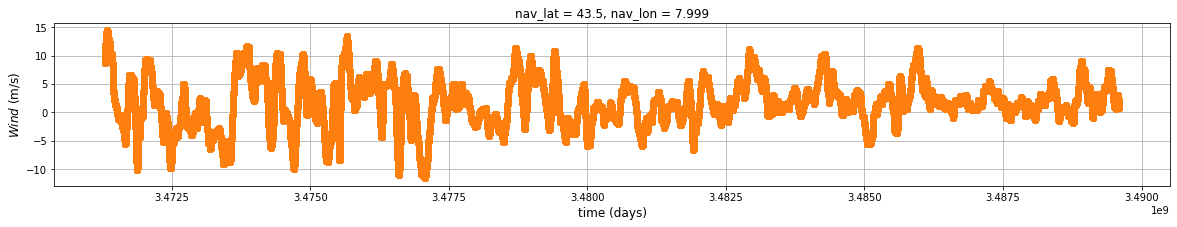

In [10]:
U10c.plot(x="time_counter",marker="o")
U10c.plot(x="time_counter",marker="o")
plt.rcParams["figure.figsize"] = (20,3)
plt.grid('on')
plt.ylabel('$Wind$ (m/s)', fontsize=12)
plt.xlabel('time (days)', fontsize=12)

In [70]:
# Ageostrophic component
Uag = Ut - Ug #ageostrophic component
Vag = Vt - Vg #ageostrophic component

## 3. 1D Model functions

#### 1D Model 

\begin{equation}
\dfrac{\partial \vec{U}}{\partial t}= -f_c\vec{k} \times \vec{U} + \dfrac{\partial}{\partial z} \left( \kappa \dfrac{\partial \vec{U}}{\partial z}\right)                                                            
\end{equation}

With boundary conditions:

At the surface:

\begin{equation}
\vec{\tau}=  \rho_{0}\kappa\, \frac{\partial\vec{U}}{\partial z}\bigg|_{surface} =  C_{d} \rho_{air} \parallel \vec{U_{10}} \parallel \vec{U_{10}}
\end{equation}

\begin{equation}
\kappa\, \frac{\partial\vec{U}}{\partial z}\bigg|_{surface} = \dfrac{\rho_{air}}{\rho_{0}}  C_{d} \parallel \vec{U_{10}} \parallel \vec{U_{10}}
\end{equation}

At the bottom

\begin{equation}
\vec{\tau}= \kappa\, \frac{\partial\vec{U}}{\partial z}\bigg|_{bottom} =  \left[\frac{0.4}{\ln\left(\frac{\Delta Z}{Z_0} \right)}\right]^2 \parallel \vec{U_{(z)}} \parallel \vec{U_{(z)}}
\end{equation}


For discretization:

First we integrate between $Z_{K+1/2}$ and $Z_{K-1/2}$:

\begin{equation}
\dfrac{\partial \vec{U}}{\partial t}= -f_c\vec{k} \times \vec{U} + \dfrac{1}{Z_{k+1/2}-Z_{k-1/2}} \left(\kappa_{k+1/2}\dfrac{\partial \vec{U}}{\partial z}\bigg|_{Z_{K+1/2}} - \kappa_{k-1/2}\dfrac{\partial \vec{U}}{\partial z}\bigg|_{Z_{K-1/2}} \right)
\end{equation}

For the first layer:

\begin{equation}
\dfrac{\partial \vec{U}}{\partial t}= -f_c\vec{k} \times \vec{U} + \dfrac{1}{Z_{k+1/2}-Z_{k-1/2}} \left(\underbrace{\kappa_{k+1/2}\dfrac{\partial \vec{U}}{\partial z}\bigg|_{Z_{K+1/2}}}_{\dfrac{\rho_{air}}{\rho_{0}} C_{d} \parallel \vec{U_{10}} \parallel \vec{U_{10}}} - \kappa_{k-1/2}\dfrac{\partial \vec{U}}{\partial z}\bigg|_{Z_{K-1/2}} \right)
\end{equation}


For the last layer

\begin{equation}
\dfrac{\partial \vec{U}}{\partial t}= -f_c\vec{k} \times \vec{U} + \dfrac{1}{Z_{k+1/2}-Z_{k-1/2}} \left(\kappa_{k+1/2}\dfrac{\partial \vec{U}}{\partial z}\bigg|_{Z_{K+1/2}} - \underbrace{\kappa_{k-1/2}\dfrac{\partial \vec{U}}{\partial z}\bigg|_{Z_{K-1/2}}}_{\left[\frac{0.4}{\ln\left(\frac{\Delta Z}{Z_0} \right)}\right]^2 \parallel \vec{U_{(z)}} \parallel \vec{U_{(z)}}} \right)
\end{equation}



Derivatives along z are computed using a second forward and backward schemes and for time discretization a first order explicit Euler scheme is used.



\begin{equation}
\dfrac{\partial \vec{U^n_k}}{\partial t}= -f_c\vec{k} \times \vec{U^n_k} + \dfrac{1}{Z_{k+1/2}-Z_{k-1/2}} \left({\kappa_{k+1/2}}\, 2\dfrac{\vec{U^n}_{k+1}-\vec{U^n}_{k}}{Z_{k+3/2}-z_{k-1/2}} - {\kappa_{k-1/2}}\, 2\dfrac{\vec{U^n}_{k}-\vec{U^n}_{k-1}}{Z_{k+1/2}-Z_{k-3/2}} \right)
\end{equation}

where,
\begin{equation}
\kappa_{k+1/2} = \dfrac{\kappa_{k+1}+\kappa_{k}}{2}
\end{equation}

and

\begin{equation}
\kappa_{k-1/2} = \dfrac{\kappa_{k}+\kappa_{k-1}}{2}
\end{equation}

Finally, the discretization in time gives:

\begin{equation}
\vec{U^{n+1}_k} = \vec{U^{n}_k} + \Delta t \dfrac{\partial \vec{U^n_k}}{\partial t}
\end{equation}

                        U component
\begin{equation}
\dfrac{\partial U^n_k}{\partial t}= f_c V^n_k + \dfrac{1}{Z_{k+1/2}-Z_{k-1/2}} \left({\kappa_{k+1/2}}\, 2\dfrac{U^n_{k+1}-U^n_{k}}{Z_{k+3/2}-Z_{k-1/2}} - {\kappa_{k-1/2}}\, 2\dfrac{U^n_{k}-U^n_{k-1}}{Z_{k+1/2}-Z_{k-3/2}} \right)
\end{equation}

\begin{equation}
U^{n+1}_k = U^{n}_k + \Delta t \dfrac{\partial U^n_k}{\partial t}
\end{equation}

                        V component
\begin{equation}
\dfrac{\partial V^n_k}{\partial t}= -f_c U^n_k + \dfrac{1}{Z_{k+1/2}-Z_{k-1/2}} \left({\kappa_{k+1/2}}\, 2 \dfrac{V^n_{k+1}-V^n_{k}}{Z_{k+3/2}-Z_{k-1/2}} - {\kappa_{k-1/2}}\, 2 \dfrac{V^n_{k}-V^n_{k-1}}{Z_{k+1/2}-Z_{k-3/2}} \right)
\end{equation}

\begin{equation}
V^{n+1}_k = V^{n}_k + \Delta t \dfrac{\partial V^n_k}{\partial t}
\end{equation}

Stability condition:

\begin{equation}
\Delta t \leq \dfrac{2 \Delta z^2}{4\kappa-f\Delta z^2}
\end{equation}

In [12]:
def oneD_explicit_model_cons(lon,lat,time, dtime,save_time, Surf_boundary_U, Surf_boundary_V, bott_boundary,K_method,K_Ekman, K, Tg, Sg,shape, Z, Z0):

    """Computation of velocities at different depths for a given point in a determined longitude and latitude 
    using an explicit scheme from 1D model theory. This function works with given values of eddy viscosity and
    boundary conditions. At the surface (parametrization of momentum), for bottom are considereded two possibilities:
    consider a logartimic bottom layer or consider velocity at bottom = 0.
    
    • lon: Longitude at wich is desired to compute the velocities
    • lat: Latitude at wich is desired to compute the velocities
    • time: Total time for the simulation, ex: Total number of days
    • dtime: Delta t
    • save_time: every how many steps you want to save the result
    • Surf_boundary_U: Boundary condition at the surface (U direction). Shape of this array: 1 x Ntime steps
    • Surf_boundary_V: Boundary condition at the surface (V direction). Shape of this array: 1 x Ntime steps
    • bott_boundary: Indicate "log" if you want to consider the stress at the bottom as boundary condition. This 
      consider a logaritmic bottom layer. Indicate "slip" if you want to consider the velocity at bottom as zero
    • K_method: Indicate "given" to compute eddy viscosity using the averages from the given vector, "PP" to compute it using
      the Pacanowski and Philander parametrization, or "Kinetic" to use the assumption of balance in kinetic energy to compute
      eddy viscosity      
    • K_Ekman: Value for eddy viscosity inside the Ekman Depth. This is use only in the method "PP" to compute eddy viscosity
    • K: vector of eddy viscosity (in case this is given). Each layer has a value of eddy viscosity
    • Tg: Temperature vector
    • Sg: Salinity vector
    • Shape: This parameter is only for the ciomputation of edddy viscosity using the "kinetic" method. This is a constant 
      between 0.5-1 taking into account the state of the sea surface
    • Z: vector that contains the levels(heights)
    • Z0: roughness length for bottom boundary condition (in case of using bottom logaritmic boundary condition)"""
    
    
    #Initialize arrays
    
    layer = len(Z) - 1
    
    print("number of layers: ",layer)
    print("Deltat: ",dtime)
    print("Deltaz: ",Z[0]-Z[1])
    
    Uk = np.zeros((layer+1, 2))  
    Vk = np.zeros((layer+1, 2))
    
    
    # Initial values
    Uk[1::,0] = 0
    Vk[1::,0] = 0
    
    t = 0
    s = 0
    n = 0
    
    # Coriolis parameter and Ekman depth
    fc = 2*2*np.pi/86164*np.sin(lat*np.pi/180)
    Uf = np.sqrt(np.sqrt(Surf_boundary_U**2+Surf_boundary_V**2))
    E_depth = 0.040 * (Uf/fc)
    
    #Vector to save the results
    
    Ur = np.zeros((layer,int((time/dtime)/save_time)+1))
    Vr = np.zeros((layer,int((time/dtime)/save_time)+1))
    Kr = np.zeros((layer,int((time/dtime)/save_time)+1))
    tr = np.zeros((int((time/dtime)/save_time)+1))
    Rifr = np.zeros((layer,int((time/dtime)/save_time)+1))
    
    # Velocities computation 
    
    while t <= (int((time/dtime))):
        #print("t",t)
        #print("s",s)
        
        "Computation of derivatives along z"
        
        dU_dzf = tl.derivative_1Dmodel(Uk[:,0][:,None],Z[:,None], 2, 'forward')
        #print("dU_dzf",dU_dzf)
        dU_dzb = tl.derivative_1Dmodel(Uk[:,0][:,None],Z[:,None], 2, 'backward')
    
        dV_dzf = tl.derivative_1Dmodel(Vk[:,0][:,None],Z[:,None],2,'forward')
        #print("dV_dzf",dV_dzf)
        dV_dzb = tl.derivative_1Dmodel(Vk[:,0][:,None],Z[:,None],2,'backward')
        
        
        "Computation of Eddy viscosity"
        
        if K_method == "PP" or K_method == "Kinetic" :
            
            #Derivatives of T and S
            # It is not needed the forward derivative of T and S for the computation of the richarson number k+1/2 for
            #the velocity value in the first layer since I replace this first forward derivative*eddy viscosity for the
            # whole surface boundary condition. Here is only add a syntethic first layer of T and U with value of zero
            # just to the code be able to compute the derivatives.# For bottom boundary condition is take the value as
            #zero and this is done automatically by the code that compute the derivative
            
            Tmod = np.insert(Tg, 0, 0, axis=0) #This insert an additional first row =0 just to the code be able to compute derivatives
            Smod = np.insert(Sg, 0, 0, axis=0) #This insert an additional first row =0 just to the code be able to compute derivatives

            
            dT_dzf = tl.derivative_1Dmodel(Tmod[:,t][:,None],Z[:,None], 2, 'forward')
            #print("dT_dzf",dT_dzf)
            dT_dzb = tl.derivative_1Dmodel(Tmod[:,t][:,None],Z[:,None], 2, 'backward')

            dS_dzf = tl.derivative_1Dmodel(Smod[:,t][:,None],Z[:,None], 2, 'forward')
            #print("dS_dzf",dS_dzf)
            dS_dzb = tl.derivative_1Dmodel(Smod[:,t][:,None],Z[:,None], 2, 'backward')  
            #print("dS_dzb",dS_dzb)
            
            # Computation of Richardson number
            
            M2_f = ((dU_dzf**2) + (dV_dzf**2)) #Prandtl frequency
            #print("M2_f", M2_f)
            zeros_f = np.where(M2_f<1e-06,1111111,M2_f)
            Brunt_f = (9.81 * 1.5e-04 * dT_dzf - 9.81 * 7e-04 *dS_dzf)
            #print("Brunt_f",Brunt_f)
            Rif = np.divide(Brunt_f, zeros_f, out=np.ones_like(Brunt_f)*100, where=zeros_f!=1111111)
            
            #print("Rif",Rif)
            
            
            M2_b = ((dU_dzb**2) + (dV_dzb**2)) #Prandtl frequency
            #print("din_b",din_b)
            zeros_b = np.where(M2_b<1e-06,1111111,M2_b)
            Brunt_b = (9.81 * 1.5e-04 * dT_dzb - 9.81 * 7e-04 *dS_dzb)
            Rib = np.divide(Brunt_b, zeros_b, out=np.ones_like(Brunt_b)*100, where=zeros_b!=1111111)
            #print("Rib",Rib)
        
            if K_method == "PP":

                # Computation of eddy viscosity 
                Kf = (1e-04 + (5e-03/((1+5*Rif)**2)))
                Kb = (1e-04 + (5e-03/((1+5*Rib)**2)))
        
                #Here is set the eddy viscosity as 1.5e-03 inside the Ekman depth
                dif = Z[0] - E_depth[t]
        
                Kf[np.where(Z[0:len(Z)-1]>dif)] = K_Ekman
                Kb[np.where(Z[1::]>dif)] = K_Ekman
            
            elif K_method == "Kinetic":
                
                Rif = np.where(Rif<1e-06,1e-06,Rif)
                Rif = np.where(Rif>100,100,Rif)
                
                Rib = np.where(Rib<1e-06,1e-06,Rib)
                Rib = np.where(Rib>100,100,Rib)
                
                # Computation of (1-Rf), Rf is the Richardson flux
                
                Dif_Rf_f = 4/(1.1*Rif + ((1.1**2)*(Rif**2)+4)**(1/2))**2
                print("Dif_Rf_f",np.squeeze(Dif_Rf_f))
                Dif_Rf_b = 4/(1.1*Rib + ((1.1**2)*(Rib**2)+4)**(1/2))**2
                #print("Dif_Rf_b",Dif_Rf_b)
                
                # Computation of mixing length
                
                Lm_f = 0.4 * Z[0:len(Z)-1][:,None] * (1-(shape*Z[0:len(Z)-1][:,None]/Z[0])) * Dif_Rf_f
                #print("Lm_f",Lm_f)
                Lm_b = 0.4 * Z[1::][:,None] * (1-(shape*Z[1::][:,None]/Z[0])) * Dif_Rf_b
                #print("Lm_b",Lm_b.shape)
                
                # Prandtl frencuency M2= (du/dz)^2 + (dv/dz)^2 is above in the computation of Richardson number
                # Computation of eddy viscosity
                
                Kf = Lm_f**2 * M2_f * Dif_Rf_f**(1/2)
                #Kf = np.where(Kf<1e-04,1e-04,Kf)
                #print("Kf",Kf[-1])
                Kb = Lm_b**2 * M2_b * Dif_Rf_b**(1/2)
                #Kb= np.where(Kb<1e-04,1e-04,Kb)
                #print("Kb",Kb)

        else:
            Rif=0
            #Computation of eddy viscosity as the averages of the given vector values
            Kf = tl.eddy_visc_aver(K,"forward")
            #print("Kf",Kf)
            Kb = tl.eddy_visc_aver(K,"backward")
            #print("Kb",Kb)
        
        "Computation of Delta Z"
        
        deltaz = np.delete(Z - np.roll(Z,-1,axis = 0),-1,0)[:,None]
        
        "Computation of time derivatives and velocities, here is changed the order of computation of the velocities"
        "to ensure energy conservation "
        
        if ((t+1)%2) == 0:
        
            # First is computed V:
            #print("Kf ent",Kf)
            #print("Kb ent",Kb)
            dV_dt = - fc * np.delete(Uk[:,0][:,None],0,0) + ( ( 1/ deltaz) * ( Kf * dV_dzf - Kb * dV_dzb ) )
        
            #here is changed the value of first layer since here is necessary to use the boundary condition at the surface
        
            dV_dt[0] =  -fc * Uk[1,0] + ( ( 1/ deltaz[0]) * ( Surf_boundary_V[t] - Kb[0] * dV_dzb[0] ) )
        
            if bott_boundary == 'log':
        
                #here is changed the value of last layer since here is necessary to use the boundary condition at the bottom

                bottom_V = ((0.4/(np.log((deltaz[-1]/2)/Z0)))**2 ) * np.sqrt(((Uk[-1,0])**2)+((Vk[-1,0])**2))* Vk[-1,0]
                dV_dt[-1] = -fc * Uk[-1,0] + ( ( 1/ deltaz[-1]) * ( Kf[-1] * dV_dzf[-1] - bottom_V ) ) 
            
            Vk[1::,1][:,None] = Vk[1::,0][:,None] + dtime*86400*dV_dt    
            Vk[1::,0][:,None] = Vk[1::,1][:,None]
            Vk[1::,1][:,None] = 0  
            #print("Vk",Vk[1::,0][:,None])
            
            # After is computed U:
            
            dU_dt =   fc * np.delete(Vk[:,0][:,None],0,0) + ( ( 1/ deltaz) * ( Kf * dU_dzf - Kb * dU_dzb ) )
        
            #here is changed the value of first layer since here is necessary to use the boundary condition at the surface
        
            dU_dt[0] =   fc * Vk[1,0] + ( ( 1/ deltaz[0]) * ( Surf_boundary_U[t] - Kb[0] * dU_dzb[0] ) )

            if bott_boundary == 'log':
        
                #here is changed the value of last layer since here is necessary to use the boundary condition at the bottom
       
                bottom_U = ((0.4/(np.log((deltaz[-1]/2)/Z0)))**2 ) * np.sqrt(((Uk[-1,0])**2)+((Vk[-1,0])**2))* Uk[-1,0]
                dU_dt[-1] =  fc * Vk[-1,0] + ( ( 1/ deltaz[-1]) * ( Kf[-1] * dU_dzf[-1] - bottom_U ) )
        
            Uk[1::,1][:,None] = Uk[1::,0][:,None] + dtime*86400*dU_dt
            Uk[1::,0][:,None] = Uk[1::,1][:,None]
            Uk[1::,1][:,None] = 0   
            #print("Uk",Uk[1::,0][:,None])
            
        else:
            
            # First is computed U:
            
            dU_dt =   fc * np.delete(Vk[:,0][:,None],0,0) + ( ( 1/ deltaz) * ( Kf * dU_dzf - Kb * dU_dzb ) )
        
            #here is changed the value of first layer since here is necessary to use the boundary condition at the surface
        
            dU_dt[0] =   fc * Vk[1,0] + ( ( 1/ deltaz[0]) * ( Surf_boundary_U[t] - Kb[0] * dU_dzb[0] ) )

            if bott_boundary == 'log':
        
                #here is changed the value of last layer since here is necessary to use the boundary condition at the bottom
       
                bottom_U = ((0.4/(np.log((deltaz[-1]/2)/Z0)))**2 ) * np.sqrt(((Uk[-1,0])**2)+((Vk[-1,0])**2))* Uk[-1,0]
                dU_dt[-1] =  fc * Vk[-1,0] + ( ( 1/ deltaz[-1]) * ( Kf[-1] * dU_dzf[-1] - bottom_U ) )
        
            Uk[1::,1][:,None] = Uk[1::,0][:,None] + dtime*86400*dU_dt
            Uk[1::,0][:,None] = Uk[1::,1][:,None]
            Uk[1::,1][:,None] = 0
            #print("Uk",Uk[1::,0][:,None])
            
            # After is computed V:
            
            dV_dt = - fc * np.delete(Uk[:,0][:,None],0,0) + ( ( 1/ deltaz) * ( Kf * dV_dzf - Kb * dV_dzb ) )
        
            #here is changed the value of first layer since here is necessary to use the boundary condition at the surface
        
            dV_dt[0] =  -fc * Uk[1,0] + ( ( 1/ deltaz[0]) * ( Surf_boundary_V[t] - Kb[0] * dV_dzb[0] ) )
        
            if bott_boundary == 'log':
        
            #here is changed the value of last layer since here is necessary to use the boundary condition at the bottom
        
                bottom_V = ((0.4/(np.log((deltaz[-1]/2)/Z0)))**2 ) * np.sqrt(((Uk[-1,0])**2)+((Vk[-1,0])**2))* Vk[-1,0]
                dV_dt[-1] = -fc * Uk[-1,0] + ( ( 1/ deltaz[-1]) * ( Kf[-1] * dV_dzf[-1] - bottom_V ) )  
            
            Vk[1::,1][:,None] = Vk[1::,0][:,None] + dtime*86400*dV_dt    
            Vk[1::,0][:,None] = Vk[1::,1][:,None]
            Vk[1::,1][:,None] = 0 
            #print("Vk",Vk[1::,0][:,None])

        if s == save_time:
            #print("n",n)
            Ur[:,n][:,None] = Uk[1::,0][:,None]
            Vr[:,n][:,None] = Vk[1::,0][:,None]
            Kr[:,n][:,None] = Kf
            Rifr[:,n][:,None] = Rif
            tr[n] = t*dtime
            #print("tr",tr[n])
            #print("Ur",Ur[:,n][:,None])
            #print("Vr",Vr[:,n][:,None])
            s = 0
            n +=1
            
        Ur[:,-1][:,None] = Uk[1::,0][:,None]
        Vr[:,-1][:,None] = Vk[1::,0][:,None]
        Kr[:,-1][:,None] = Kf
        Rifr[:,-1][:,None] = Rif
        tr[-1]= t*dtime
        
        #print("--------------------------")

        
        t += 1
        s += 1 
   
    return Ur,Vr,Kr,Rifr,tr
print('1D model function')
hide_toggle()

1D model function


#### 3.2 Plots functions

In [13]:
def plot_1D_velocities(cols,rows,U,V,gtime,time,heights):
    
    """This function allows to get the plots of velocity components along the time for each layer of the model 
    • cols: number of cols desired in the plot
    • rows: number of rows desired in the plot
    • U,V: U and V vectors result of the 1D model
    • gtime: vector that contains all the time steps of the simulation
    • time: Desired visualiwation time
    • heights: vector that contains the heigth or level at which the velocities were computed"""

    fig, ax = plt.subplots(rows, cols)
    fig.subplots_adjust(left = 1, bottom = 5, right = 2, top = 6, wspace = 0.6, hspace = 1.6)
    fig.set_size_inches(40, 40)
    
    if cols == 1:
        axm = ax[:,None]
    else: 
        axm = ax
    
    for row in range(rows):

        for col in range(cols):
            im3 = axm[row, col].plot(gtime[0:time], U[(row+col+(row*(cols-1))),0:time], lw=1.5, label='U')
            im3 = axm[row, col].plot(gtime[0:time], V[(row+col+(row*(cols-1))),0:time], lw=1.5, label='V')
            axm[row, col].grid('on')
            axm[row, col].set_ylabel('U,V (m/s)', fontsize=12)
            axm[row, col].set_xlabel('time (days)', fontsize=12)
            axm[row, col].tick_params(axis='y')
            axm[row, col].tick_params(labelsize=10)
            axm[row, col].legend(fontsize=8)
            axm[row, col].set_title("Height: {} m ".format(heights[(row+col+(row*(cols-1)))]))
            
            
def plot_1D_velocities_hours(cols,rows,U,V,gtime,time_i,time_f,heights):
    
    """This function allows to get the plots of velocity components along the time for each layer of the model 
    defining the initial and final time
    • cols: number of cols desired in the plot
    • rows: number of rows desired in the plot
    • U,V: U and V vectors result of the 1D model
    • gtime: vector that contains all the time steps of the simulation in hours
    • time_i: Desired initial visualization time
    • time_f: Desired final visualization time
    • heights: vector that contains the heigth or level at which the velocities were computed"""

    fig, ax = plt.subplots(rows, cols, figsize=(10,10))
    fig.subplots_adjust(left = 1, bottom = 5, right = 2, top = 6, wspace = 0.2, hspace = 2)
    fig.set_size_inches(40, 40)
    
    if cols == 1:
        axm = ax[:,None]
    else: 
        axm = ax
    
    for row in range(rows):

        for col in range(cols):
            im3 = axm[row, col].plot(gtime[time_i:time_f], U[(row+col+(row*(cols-1))),time_i:time_f], lw=1.5, label='U')
            im3 = axm[row, col].plot(gtime[time_i:time_f], V[(row+col+(row*(cols-1))),time_i:time_f], lw=1.5, label='V')
            axm[row, col].grid('on')
            axm[row, col].set_ylabel('U,V (m/s)', fontsize=12)
            axm[row, col].set_xlabel('time (hours)', fontsize=12)
            axm[row, col].tick_params(axis='y')
            axm[row, col].tick_params(labelsize=10) 
            #axm[row, col].set_xticks(np.arange(0, gtime[-1], 0.0008))
            axm[row, col].legend(fontsize=8)
            axm[row, col].set_title("Height: {} m ".format(heights[(row+col+(row*(cols-1)))]))
            
def plot_1D_velocities_layer(U,V,gtime,time_i,time_f,heights,layers_vector):
    
    """This function allows to get the plots of velocity components along the time for each layer of the model 
    • cols: number of cols desired in the plot
    • rows: number of rows desired in the plot
    • U,V: U and V vectors result of the 1D model
    • gtime: vector that contains all the time steps of the simulation in hours
    • time_i: Desired initial visualization time
    • time_f: Desired final visualization time
    • heights: vector that contains the heigth or level at which the velocities were computed
    • layers_vector: The vector that contains the desired layers to plot"""
    
    fig, ax = plt.subplots(len(layers_vector),1,figsize=(3,5))
    fig.subplots_adjust(left = 1, bottom = 5, right = 2, top = 6, wspace = 0.7, hspace = 0.8)
    fig.set_size_inches(20,20)
    
    for j,l in enumerate(layers_vector): 

        im1 = ax[j].plot(gtime[time_i:time_f], U[l,time_i:time_f], lw=1.5, label='U')
        im1 = ax[j].plot(gtime[time_i:time_f], V[l,time_i:time_f], lw=1.5, label='V')
        #ax[j].set_ylim([np.min(U[0,:]), np.max(U[0,:])])
        ax[j].grid('on')
        ax[j].set_ylabel('U,V (m/s)', fontsize=20)
        ax[j].set_xlabel('time (days)', fontsize=20)
        ax[j].tick_params(axis='y')
        ax[j].tick_params(labelsize=20) 
        ax[j].legend(fontsize=18)
        ax[j].set_title("Height: {} m ".format(heights[l]), fontsize=20)

print('Functions to plot oscillations of U and V along time general, detail by hours and only for 4 levels ')
hide_toggle()

Functions to plot oscillations of U and V along time general, detail by hours and only for 4 levels 


In [14]:
def plot_1D_profile(U,V,K,time,heights,t1,kappa_profile):  
    
    """ This function allows to plot the vertical profile of U and V velocities
    • U,V: arrays of velocities along the depth and time, rows are velocites at each depth, coulumns is the variation of U along         time
    • gtime: vector of time of the simulation
    • heights: Vector that constains the heights at which were found the velocities
    • t1: times at which is desired to get the plot
    • kappa_profile: indicate 'yes' if it is desire to include the eddy viscosity profile"""
    
    rows = 1
    if kappa_profile== 'yes':
        cols = 3
    else: 
        cols = 2
    
    
    fig, ax = plt.subplots(rows, cols, figsize=(10,10))
    fig.subplots_adjust(left = 2, bottom = 9, right = 3, top = 10, wspace = 0.5, hspace = 0.7)
    fig.set_size_inches(20, 20)
    
    print(ax[None,:].shape)
    
    if rows == 1:
        axm = ax[None,:]
    else: 
        axm = ax

    im1 = axm[0, 0].plot(U[:,t1],heights,'bo-', lw=2, label = "time: {} days, ".format(int(time[t1]-time[0])))
    axm[0, 0].grid('on')
    axm[0, 0].set_ylabel('Depth (m)', fontsize=18)
    axm[0, 0].set_xlabel('U (m/s)', fontsize=18)
    axm[0, 0].tick_params(axis='y')
    axm[0, 0].tick_params(labelsize=15)
    axm[0, 0].legend(fontsize=14)
    axm[0, 0].set_title(" U profile ", fontsize=20)
    axm[0, 0].invert_yaxis()

    
    im2 = axm[0, 1].plot(V[:,t1],heights, 'bo-', lw=2,  label = "time: {} days, ".format(int(time[t1]-time[0])))
    axm[0, 1].grid('on')
    axm[0, 1].set_ylabel('Height (m)', fontsize=18)
    axm[0, 1].set_xlabel('V (m/s)', fontsize=18)
    axm[0, 1].tick_params(axis='y')
    axm[0, 1].tick_params(labelsize=15)
    axm[0, 1].legend(fontsize=14)
    axm[0, 1].set_title(" V profile ", fontsize=20)
    axm[0, 1].invert_yaxis()
    
    if kappa_profile=='yes':       
        im3 = axm[0, 2].plot(K[:,t1],heights, 'bo-', lw=2,  label = "time: {} days, ".format(int(time[t1]-time[0])))
        axm[0, 2].grid('on')
        axm[0, 2].set_ylabel('Height (m)', fontsize=18)
        axm[0, 2].set_xlabel('Eddy viscosity $\kappa (m^2/s)$', fontsize=18)
        axm[0, 2].tick_params(axis='y')
        axm[0, 2].tick_params(labelsize=15)
        axm[0, 2].legend(fontsize=14)
        axm[0, 2].set_title(" $\kappa(z)$ profile ", fontsize=20)
        axm[0, 2].invert_yaxis()

print('Function to plot U and V profiles for 1 time')
hide_toggle()

Function to plot U and V profiles for 1 time


In [15]:
def plot_complex(cols,rows,U,V,gtime,ti,tf,heights):

    """This function allows to get the plots of the relation abs(U+iV) to compute the mean time
    • cols: number of cols desired in the plot
    • rows: number of rows desired in the plot
    • U,V: U and V vectors result of the 1D model
    • gtime: vector that contains all the time steps of the simulation
    • ti,tf: Desired visualization time
    • layers_vector: The vector that contains the desired layers to plot"""

    fig, ax = plt.subplots(rows, cols, figsize=(10,10))
    fig.subplots_adjust(left = 1, bottom = 5, right = 2, top = 6, wspace = 0.2, hspace = 0.6)
    fig.set_size_inches(20, 20)
                       
    if cols == 1:
        axm = ax[:,None]
    else: 
        axm = ax
    
    for row in range(rows):

        for col in range(cols):
            im1 = axm[row, col].plot(gtime[ti:tf], np.abs(U[(row+col+(row*(cols-1))),ti:tf]+(1j*V[(row+col+(row*(cols-1))),0:time])), lw=1.5, label='U+iV')
            axm[row, col].grid('on')
            axm[row, col].set_ylabel('U+iV (m/s)', fontsize=20)
            axm[row, col].set_xlabel('time (days)', fontsize=20)
            axm[row, col].tick_params(axis='y')
            axm[row, col].tick_params(labelsize=18)
            axm[row, col].legend(fontsize=14)
            axm[row, col].set_title("Height: {} m ".format(heights[(row+col+(row*(cols-1)))]))
            


def plot_complex_layer(U,V,gtime,ti,tf,heights,layers_vector):

    """This function allows to get the plots of the relation abs(U+iV) to compute the mean time for the 
    desire layers
    • U,V: U and V vectors result of the 1D model
    • gtime: vector that contains all the time steps of the simulation
    • ti,tf: Desired visualization time
    • heights: vector that contains the heigth or level at which the velocities were computed
    • layer1,layer2,layer3,layer4: desire layers to plot"""
    
    fig, ax = plt.subplots(len(layers_vector),1,figsize=(3,5))
    fig.subplots_adjust(left = 1, bottom = 5, right = 2, top = 6, wspace = 0.7, hspace = 0.8)
    fig.set_size_inches(20,20)                  
    
    for j,l in enumerate(layers_vector):
    
        im1 = ax[j].plot(gtime[ti:tf], np.abs(U[l,ti:tf]+(1j*V[l,ti:tf])), lw=1.5, label='|U+iV|')
        ax[j].grid('on')
        ax[j].set_ylabel('|U+iV|', fontsize=20)
        ax[j].set_xlabel('time (days)', fontsize=20)
        ax[j].tick_params(axis='y')
        ax[j].tick_params(labelsize=18)
        ax[j].legend(fontsize=14)
        ax[j].set_title("Height: {} m ".format(heights[l]), fontsize=21)
            
print('Function to plot |U+iV| (magnitude) for each layer and specific given layers')

hide_toggle()

Function to plot |U+iV| (magnitude) for each layer and specific given layers


## 4. Experiments

### 4.1 Whole time

In [16]:
# Time variables
dtime1= 50/86400
days = 210.9
save_data1 = int((1/24)/dtime1) #Save data each hour

In [17]:
# Definition of surface boundary condition

# Computation of wind stress and surface boundary condition

rho_air = 1.225
rho_water = 1027
Cd1 = 7.94e-5*Wind_norm + 6.12e-4

Shear_x1 = rho_air * Cd1 * Wind_norm * U10c
Shear_y1 = rho_air * Cd1 * Wind_norm * V10c

BC_u1 = Shear_x1.values / rho_water
BC_v1 = Shear_y1.values / rho_water

#BC_u1 = taux_w.values  / rho_water
#BC_v1 = tauy_w.values  / rho_water

print(BC_v1.shape)

(364608,)


In [19]:
# Definition of levels
z1 = np.linspace(302,0,152) # Levels
H_V1 = np.diff(z1)/2 + z1[0:z1.shape[0]-1] #Heights at wich velocities are computed
z1_plots = np.max(z1)-H_V1

# Definition of eddy viscosity (kappa)
K1 = np.zeros(z1.shape[0]-1)
K1[:] = 0.0015

In [20]:
# Computation of velocities                            
U1,V1,Kr1,Rif1,tr1 = oneD_explicit_model_cons(8, 43.5, days, dtime1, save_data1, BC_u1, BC_v1, 'slip','PP',1.5e-03, K1,Tc.values,Sc.values,0.75, z1, 0.001)

number of layers:  151
Deltat:  0.0005787037037037037
Deltaz:  2.0


In [21]:
np.savetxt("U1_300m_151L_2010_7months_PP1.5e-03.csv",U1,delimiter = "_")
np.savetxt("V1_300m_151L_2010_7months_PP1.5e-03.csv",V1,delimiter = "_")
np.savetxt("Kr1_300m_151L_2010_7months_PP1.5e-03.csv",Kr1,delimiter = "_")
np.savetxt("Rif1_300m_151L_2010_7months_PP1.5e-03.csv",Rif1,delimiter = "_")
np.savetxt("tr1_300m_151L_2010_7months_PP1.5e-03.csv",tr1,delimiter = "_")

In [ ]:
U1=np.genfromtxt('/home/silvatol/Documents/Stage/Codes/6.1DModel_withdata/SEVEN_MONTHS/TXT/U1_300m_151L_2010_7months_PP1.5e-03.csv', delimiter='_') 
V1=np.genfromtxt('/home/silvatol/Documents/Stage/Codes/6.1DModel_withdata/SEVEN_MONTHS/TXT/V1_300m_151L_2010_7months_PP1.5e-03.csv', delimiter='_')
Kr1=np.genfromtxt('/home/silvatol/Documents/Stage/Codes/6.1DModel_withdata/SEVEN_MONTHS/TXT/Kr1_300m_151L_2010_7months_PP1.5e-03.csv', delimiter='_')
Rif1=np.genfromtxt('/home/silvatol/Documents/Stage/Codes/6.1DModel_withdata/SEVEN_MONTHS/TXT/Rif1_300m_151L_2010_7months_PP1.5e-03.csv', delimiter='_')
tr1=np.genfromtxt('/home/silvatol/Documents/Stage/Codes/6.1DModel_withdata/SEVEN_MONTHS/TXT/tr1_300m_151L_2010_7months_PP1.5e-03.csv', delimiter='_')

In [22]:
#Interpolate results to have the same depths as the model information
z1n = new_depth_vel #Depths from the model
U1_int = np.zeros((len(z1n),int(days*24)+1))
V1_int = np.zeros_like(U1_int)
Kr1_int = np.zeros_like(U1_int)


for t in range(0,len(tr1)):
    U1_int[:,t]= np.interp(z1n,z1_plots,U1[:,t])
    V1_int[:,t]= np.interp(z1n,z1_plots,V1[:,t])
    Kr1_int[:,t]= np.interp(z1n,z1_plots,Kr1[:,t])


In [43]:
U1_int.shape

(302, 5062)

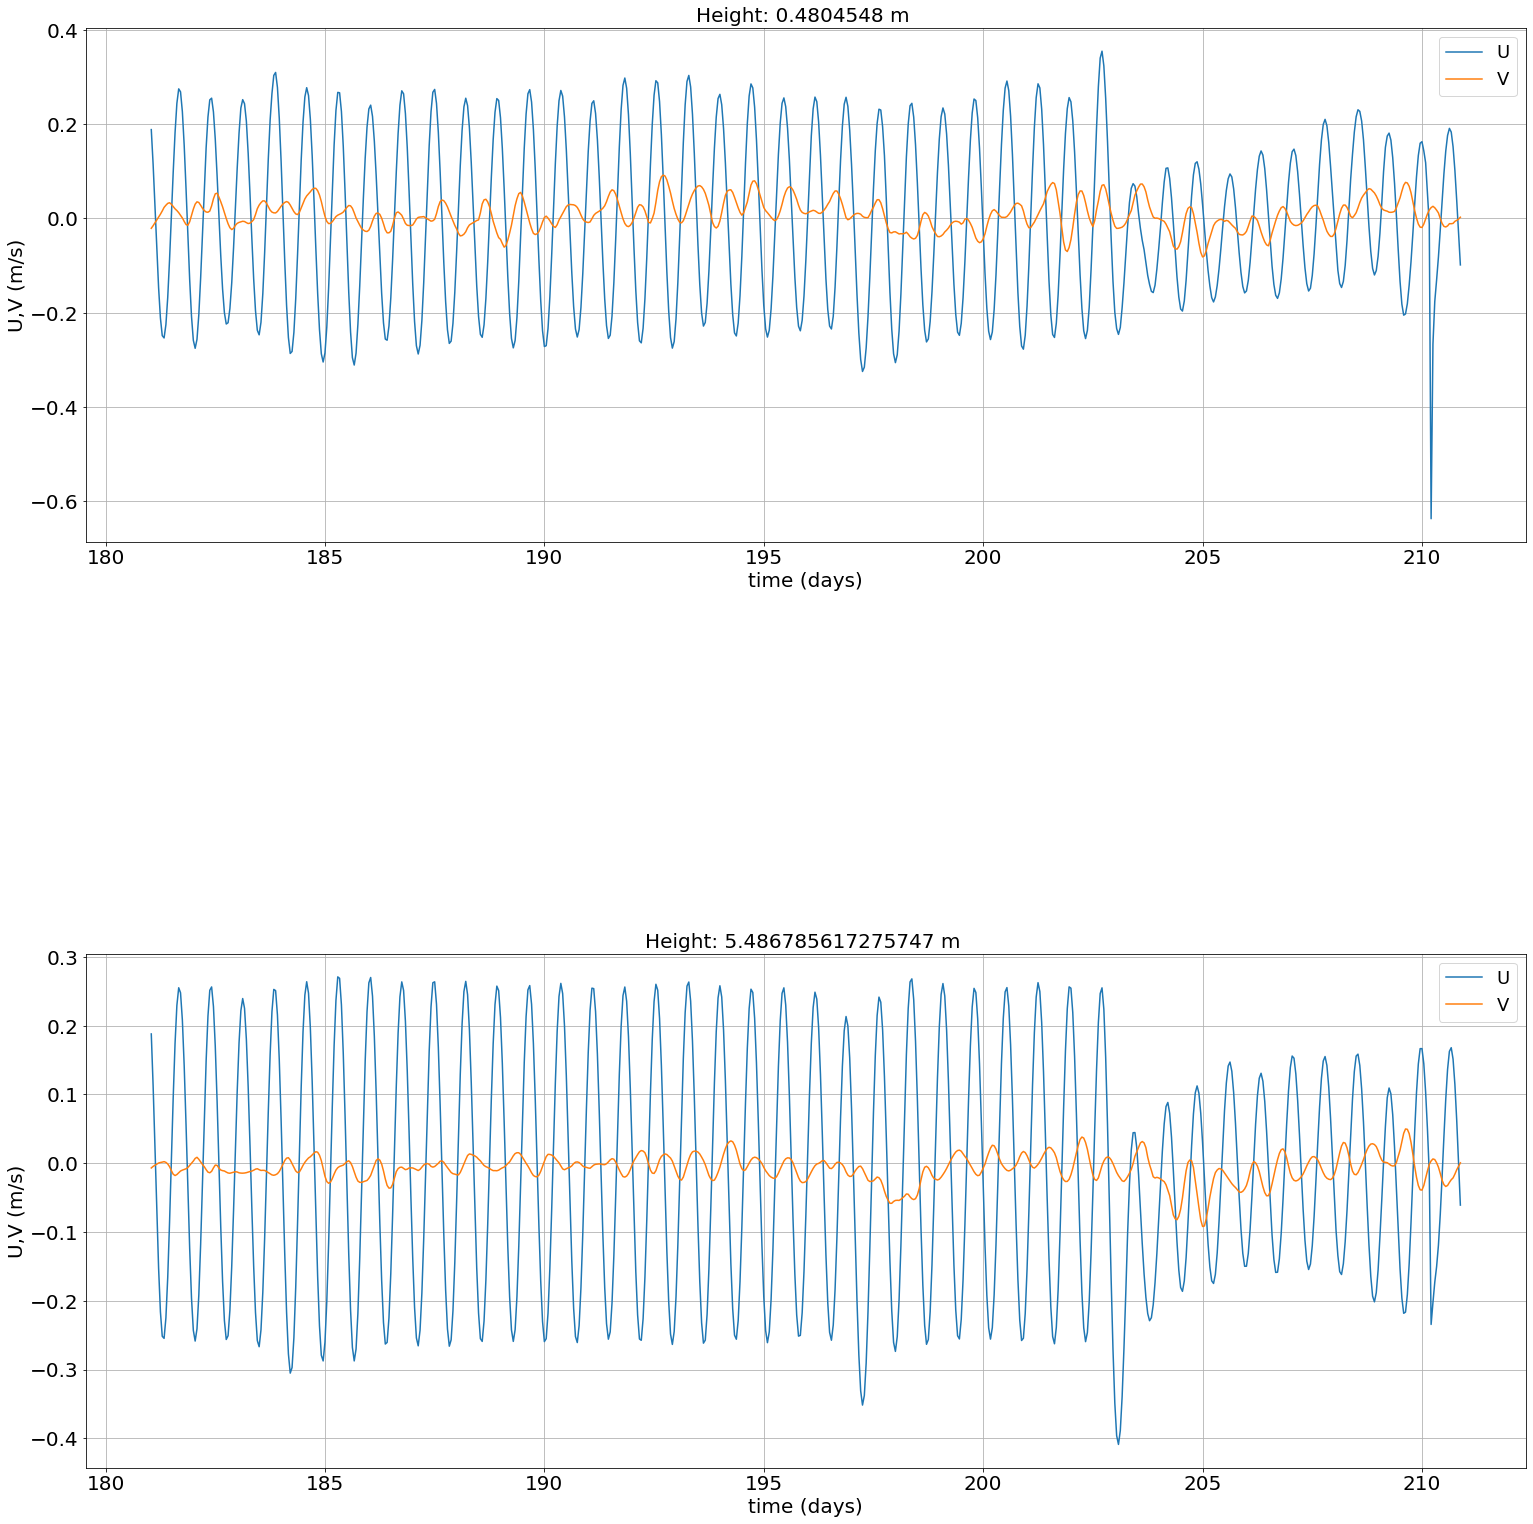

In [72]:
layers_p = np.array([0,5])
plot_1D_velocities_layer(U1_int,Uag,tr1,4344,5061,z1n,layers_p)

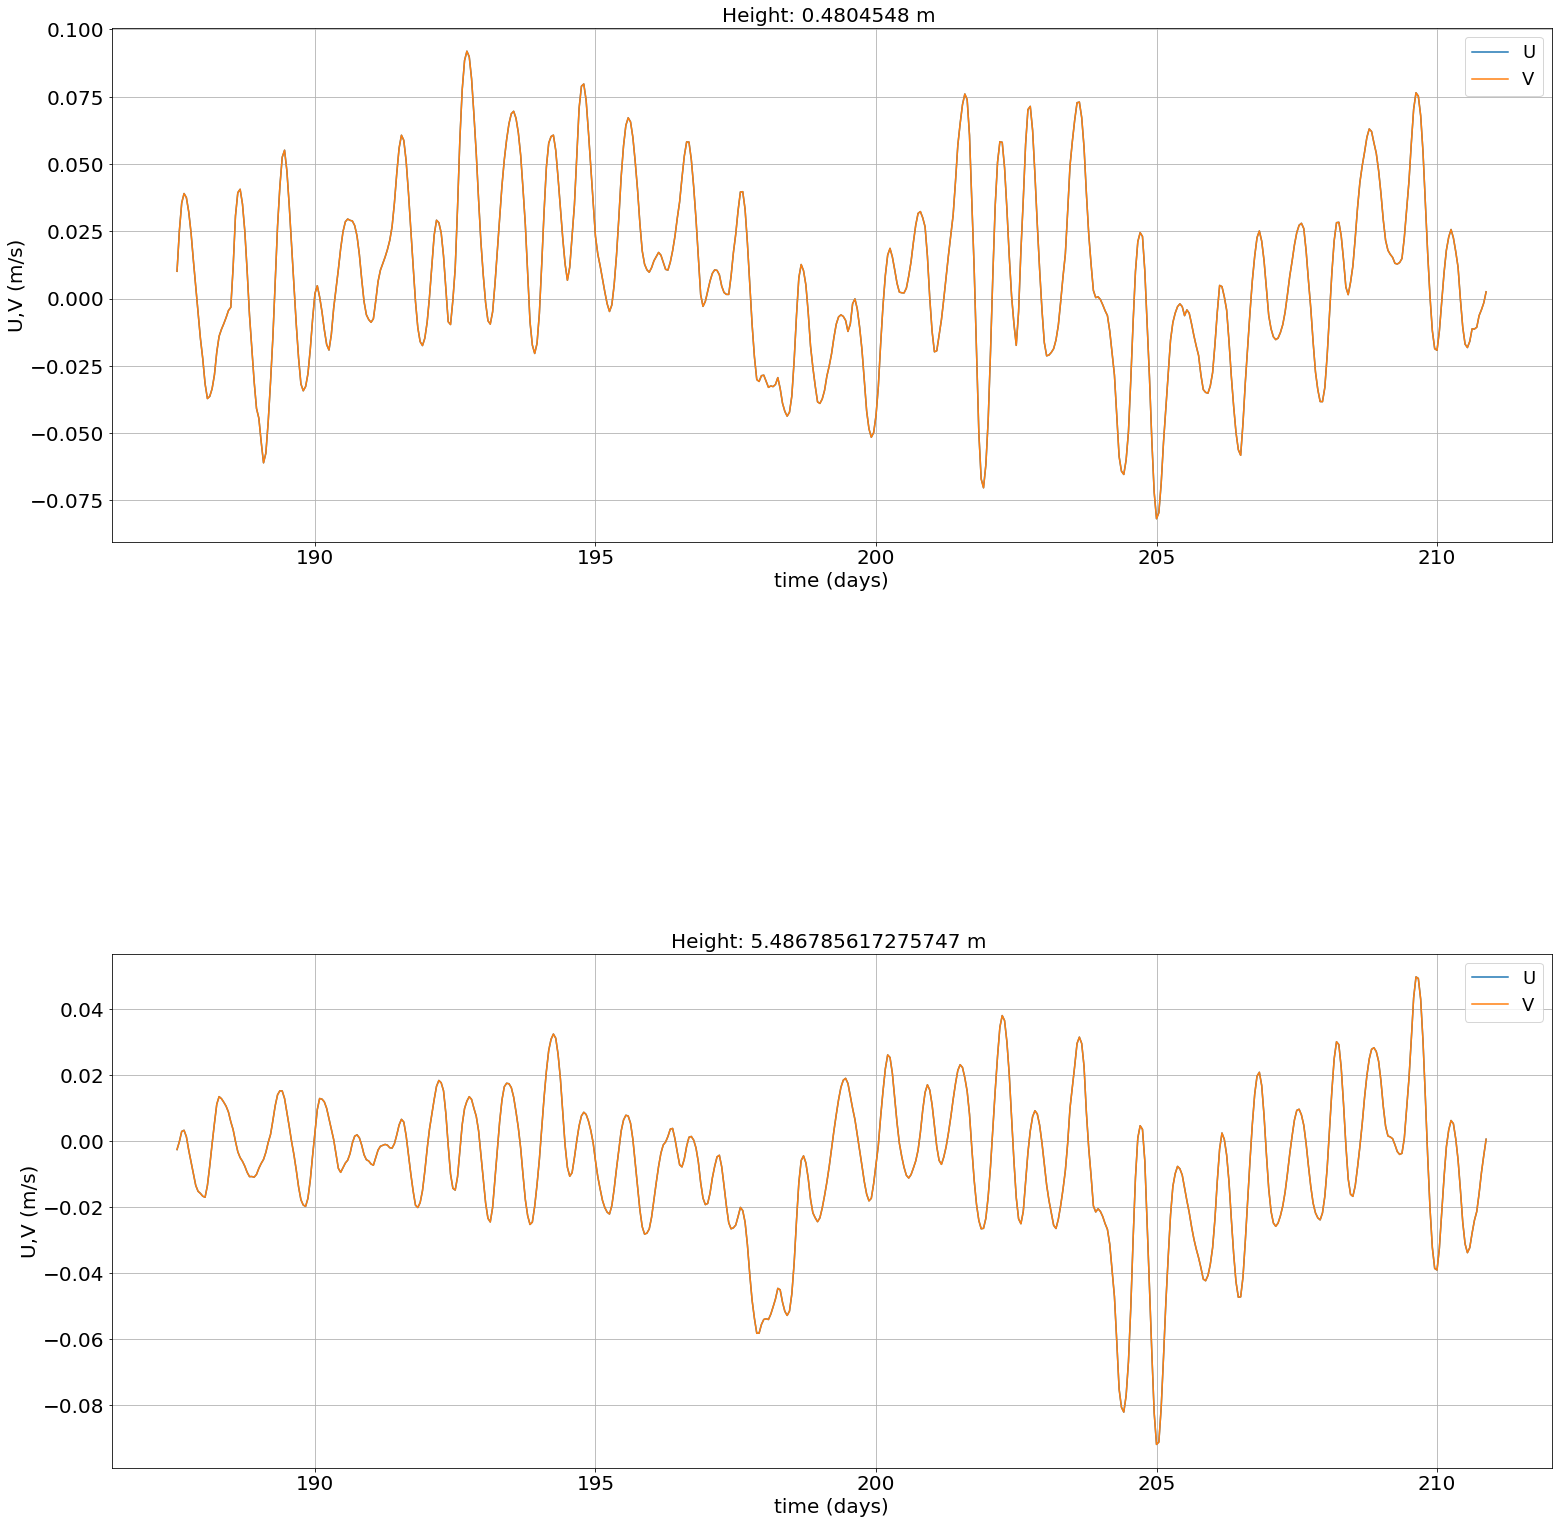

In [50]:
plot_1D_velocities_layer(Uagw,Uagw,tr1,4500,5061,z1n,layers_p)

In [ ]:
plot_complex_layer(U1_int,V1_int,tr1,744,1413,z1n,layers_p)

In [ ]:
plot_1D_profile(U1_int,V1_int,Kr1_int,tr1,z1n,1391,'yes')

In [ ]:
plot_1D_profile(Uagw,Vagw,Kr1,tr1,z1n,671,'no')